# Data Overview


In [1]:
# import necessary utilitys
import np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

merged_df = pd.concat([rating_features_data, rental_price_data['price']], axis=1)

print(rental_price_data.head())
print(rating_features_data.head())

print(rental_price_data.describe())
print(rating_features_data.describe())

     price
0  $300.00
1   $99.00
2  $100.00
3  $100.00
4  $599.00
   accommodates                                          amenities  \
0             6  {"Cable TV",Internet,"Wireless Internet","Air ...   
1             2  {"Air Conditioning",Heating,"Family/Kid Friend...   
2             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4             6  {TV,"Cable TV",Internet,"Wireless Internet","A...   

   availability_30  bathrooms  bed_type  bedrooms  beds  \
0                0        2.5  Real Bed       1.0   3.0   
1               29        0.0     Futon       1.0   1.0   
2               30        1.5  Real Bed       1.0   1.0   
3               30        1.5  Real Bed       1.0   1.0   
4               27        2.0  Real Bed       3.0   3.0   

   calculated_host_listings_count cancellation_policy  guests_included  ...  \
0                               1            moderate                1  ...   


# Nature of the Data

Display of key data characteristics

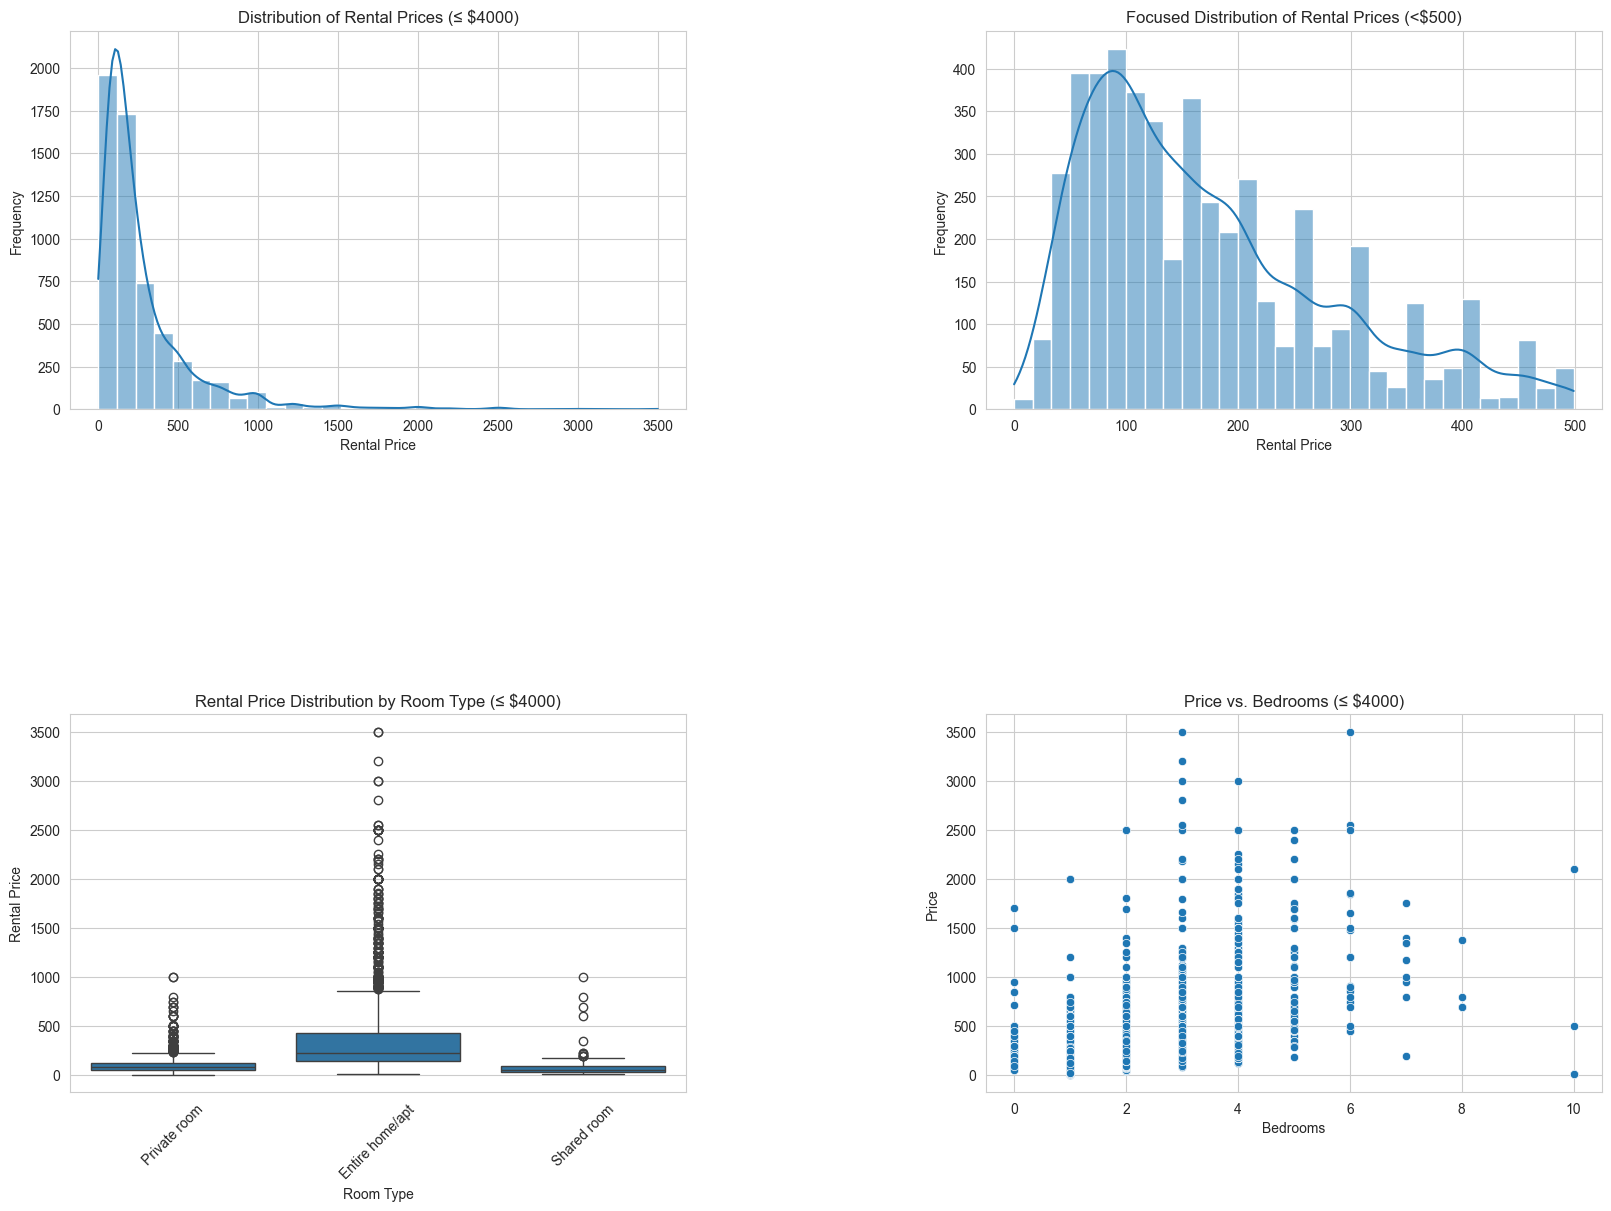

Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.


In [3]:
# Ensure 'price' is converted to numeric (float)
merged_df['price'] = pd.to_numeric(merged_df['price'].replace('[\$,]', '', regex=True), errors='coerce')
merged_df = merged_df.dropna(subset=['price'])

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'hspace': 0.4, 'wspace': 0.3}, constrained_layout=True)

# Histogram of Rental Prices
filtered_prices = merged_df[merged_df['price'] <= 4000]['price']
sns.histplot(filtered_prices, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Rental Prices (≤ $4000)')
axes[0, 0].set_xlabel('Rental Price')
axes[0, 0].set_ylabel('Frequency')

# Focused Histogram of Rental Prices
sns.histplot(merged_df[merged_df['price'] < 500]['price'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Focused Distribution of Rental Prices (<$500)')
axes[0, 1].set_xlabel('Rental Price')
axes[0, 1].set_ylabel('Frequency')

# Boxplot of Prices by Room Type
sns.boxplot(x='room_type', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 0])
axes[1, 0].set_title('Rental Price Distribution by Room Type (≤ $4000)')
axes[1, 0].set_xlabel('Room Type')
axes[1, 0].set_ylabel('Rental Price')
axes[1, 0].tick_params(axis='x', rotation=45)

# Scatter Plot of Price vs. Bedrooms
sns.scatterplot(x='bedrooms', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 1])
axes[1, 1].set_title('Price vs. Bedrooms (≤ $4000)')
axes[1, 1].set_xlabel('Bedrooms')
axes[1, 1].set_ylabel('Price')

plt.show()
print("Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.")

## Geo-Plotting of Datapoints
For visualization only, we plotted all Hotels according to their location. Please note that this is for visualization only and NOT TO SCALE. 

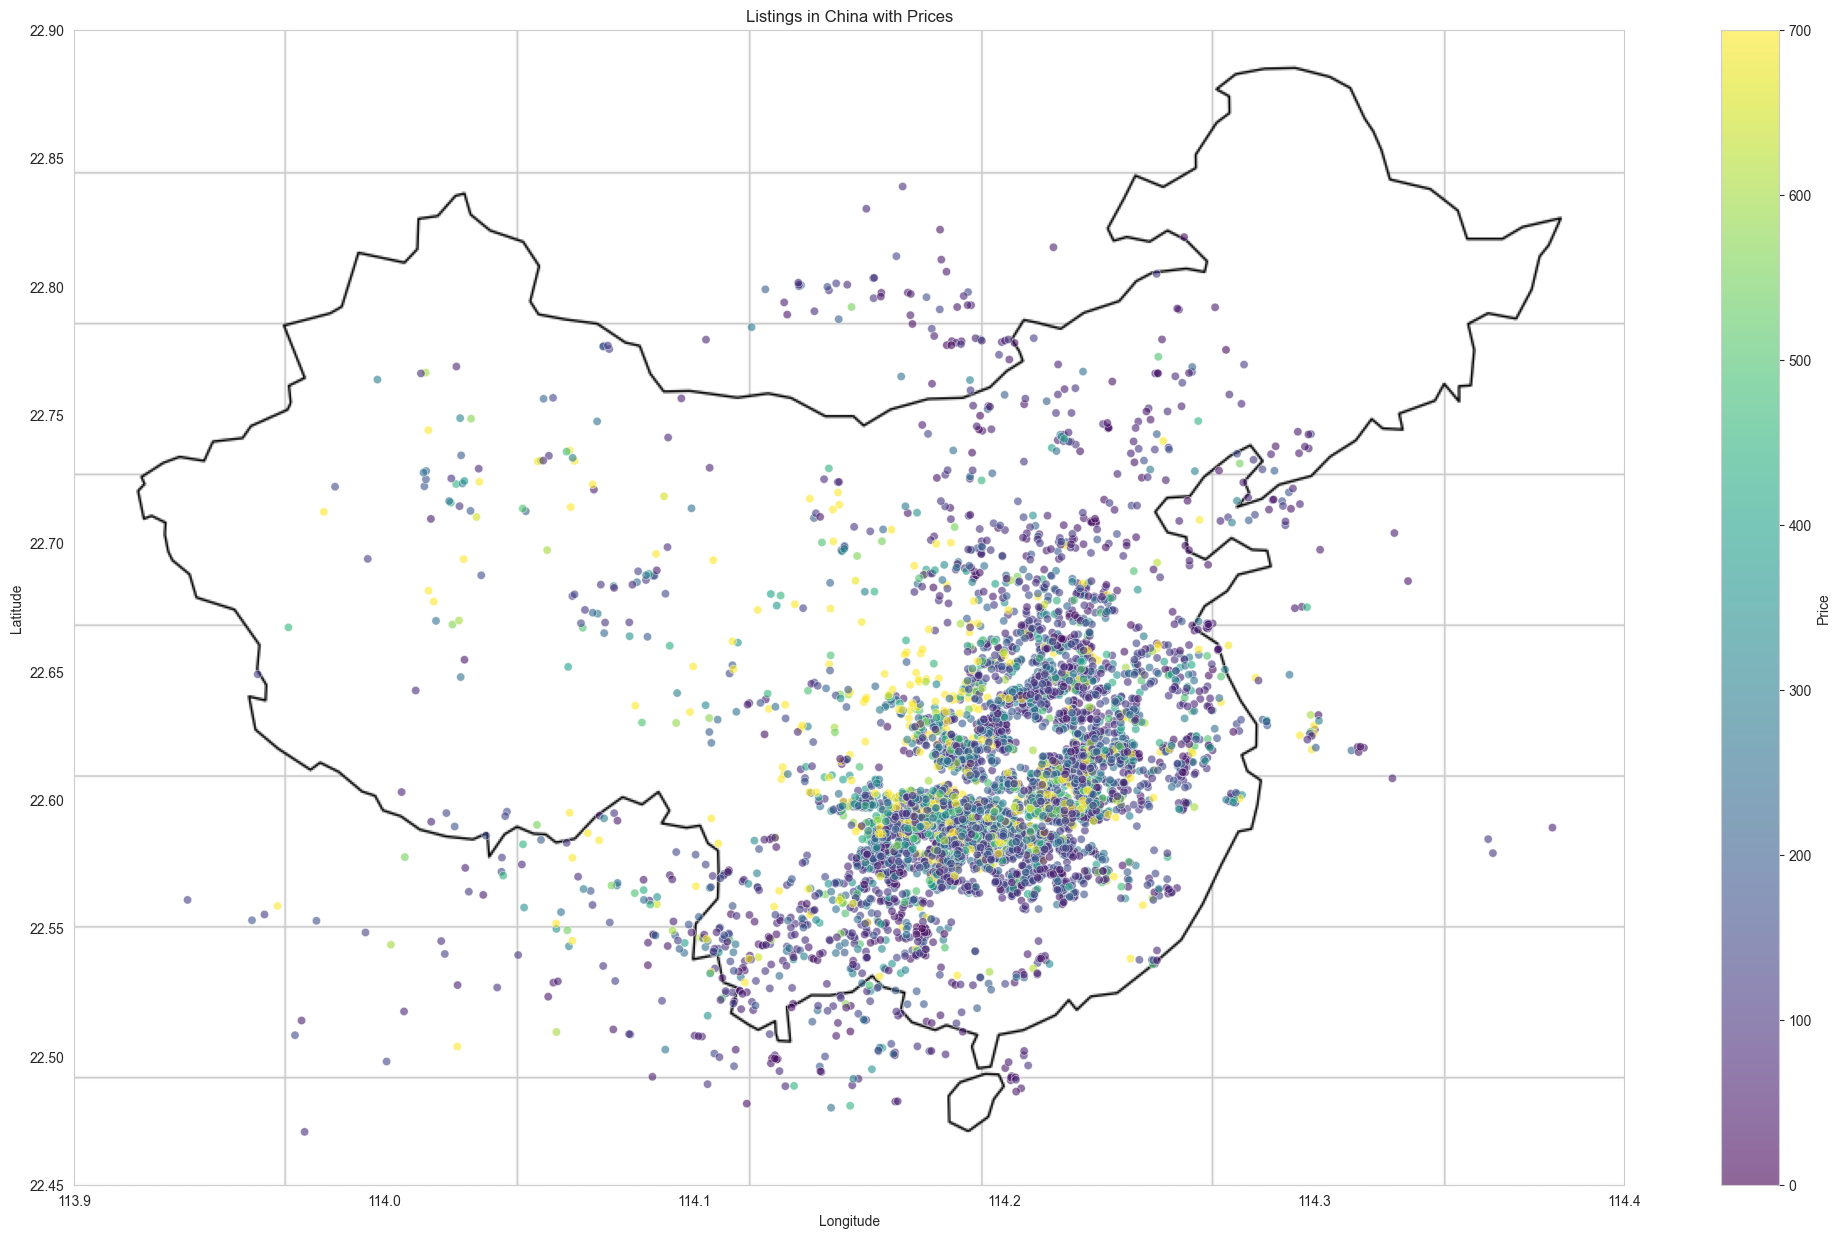

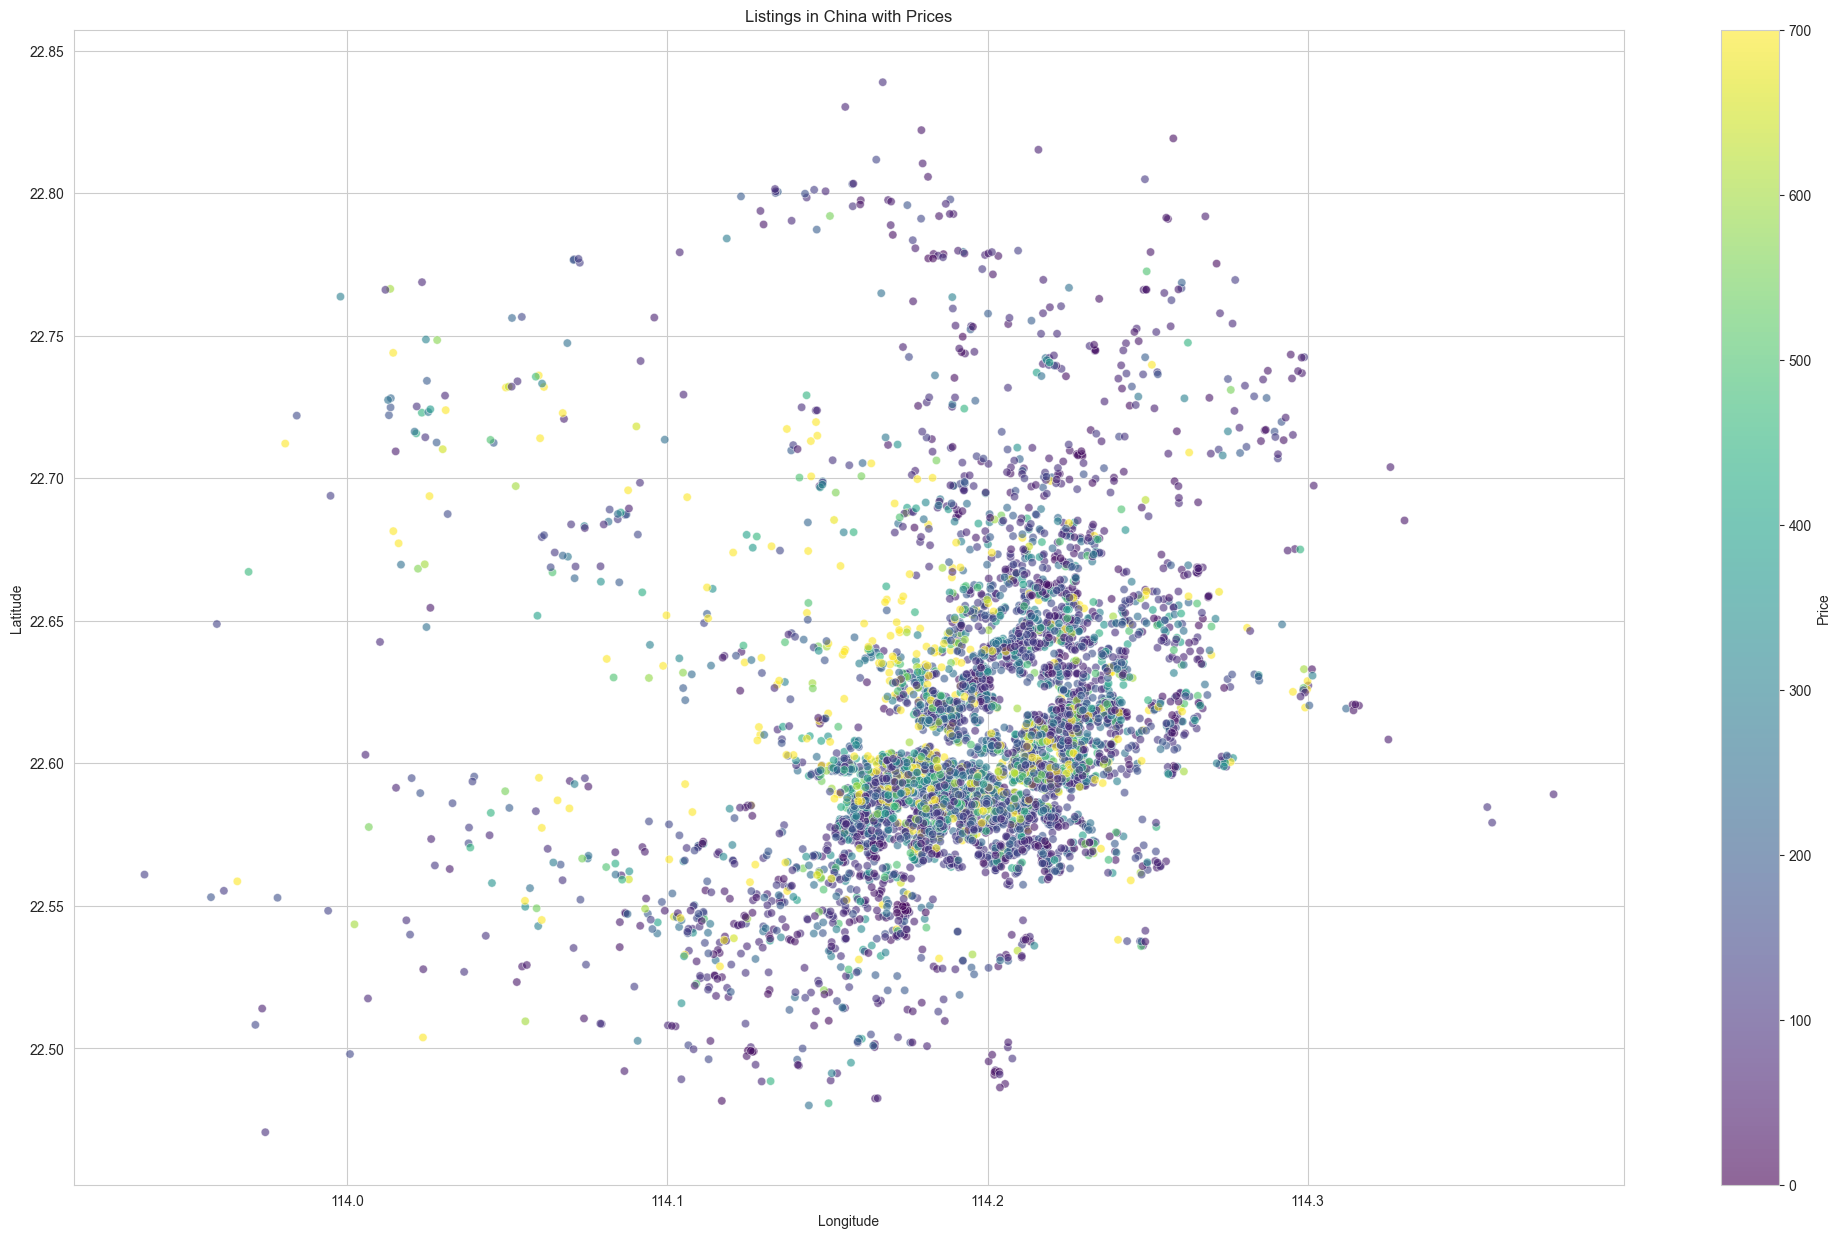

In [4]:
# Load the background image
china_map_img = mpimg.imread("map.png")

# Create a plot
fig, ax = plt.subplots(figsize=(25, 15))

# Plot the data points with color corresponding to the price
sc = ax.scatter(merged_df['longitude(East)'], merged_df['latitude(North)'],
                c=merged_df['price'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, zorder=1)
sc.set_clim(0, 700)

# Display the background image
ax.imshow(china_map_img, extent=[113.9, 114.4, 22.45, 22.9], aspect='auto', zorder=0)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Price')

# Set plot title and labels
ax.set_title('Listings in China with Prices')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove gridlines
ax.grid(False)

# Set axis limits explicitly to prevent image from affecting zoom
ax.set_xlim(113.9, 114.4)
ax.set_ylim(22.45, 22.9)

# Show the plot
plt.show()

# create plot with no map in background
# Create a plot
fig, ax = plt.subplots(figsize=(25, 15))

# Plot the data points with color corresponding to the price
sc = ax.scatter(merged_df['longitude(East)'], merged_df['latitude(North)'],
                c=merged_df['price'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, zorder=1)
sc.set_clim(0, 700)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Price')

# Set plot title and labels
ax.set_title('Listings in China with Prices')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

# Preprocessing

- we only look at key amenities based on their frequency in the data set and personal observation on most important amenities.

### Missing Values
- for missing values bathrooms, beds, review_scores_checkin, review_scores_communication, review_scores_location,
review_scores_rating, review_scores_value mean was assessed. 
- for is host_is_superhost false is assumed
- for host_listings_count 1 is assumed. Therefor it is assumed that the host only has one listing.

In [5]:
# Function to extract key amenities directly from the amenities string
def extract_key_amenities_directly(amenities):
    key_amenities = ['Internet', 'Wireless Internet', 'Kitchen', 'Heating', 'Essentials', 'TV',
                     'Washer', 'Dryer', 'Free parking on premises', 'Air conditioning', 'Breakfast',
                     'Pets allowed', 'Family/kid friendly', 'Suitable for events']
    # Normalize the amenities string for consistent matching
    amenities = amenities.lower().replace('"', '').replace('{', '').replace('}', '').replace(' ', '')
    features = {amenity: 1 if amenity.lower().replace(' ', '') in amenities else 0 for amenity in key_amenities}
    return pd.Series(features)

# Apply the function to extract key amenities and add them as new columns
key_amenities_df = rating_features_data['amenities'].apply(extract_key_amenities_directly)
rating_features_data = pd.concat([rating_features_data, key_amenities_df], axis=1)
rating_features_data.drop('amenities', axis=1, inplace=True)

# Convert price from string to float
rental_price_data['price'] = rental_price_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Check for missing values
print("Before Preprocessing")
print("Missing values in rental data:", rental_price_data.isnull().sum())
print("Missing values in rating features data:", rating_features_data.isnull().sum())

# Fill missing values in 'host_is_superhost' with False
rating_features_data['host_is_superhost'].fillna('f', inplace=True)

# Fill missing values in 'host_listings_count' with 1
rating_features_data['host_listings_count'].fillna(1, inplace=True)

# Fill missing values for numerical columns with the median
for column in rating_features_data.select_dtypes(include=['float64', 'int64']).columns:
    median_value = rating_features_data[column].median()
    rating_features_data[column].fillna(median_value, inplace=True)
    
#Scale Numerical Values with MinMaxScaler
scaler = MinMaxScaler()
numerical_columns = rating_features_data.select_dtypes(include=['float64', 'int64']).columns
rating_features_data[numerical_columns] = scaler.fit_transform(rating_features_data[numerical_columns])

# Has availability is allways true. Therefor it can be dropped
rating_features_data.drop('has_availability',axis=1, inplace=True)

#Replace t and f with True and False
mapping = {'f': 0, 't': 1}
rating_features_data['host_is_superhost'] = rating_features_data['host_is_superhost'].map(mapping)
rating_features_data['instant_bookable'] = rating_features_data['instant_bookable'].map(mapping)

# Encode categorical variables using one-hot encoding
categorical_columns = ['room_type', 'bed_type', 'property_type', 'cancellation_policy']
rating_features_data = pd.get_dummies(rating_features_data, columns=categorical_columns)

#Convert all Data to numerical data
rating_features_data = rating_features_data.astype(float)

pd.set_option('display.max_columns', None)

# Convert to DataFrame and use to_string to display all columns
rental_missing = rental_price_data.isnull().sum().reset_index()
rating_missing = rating_features_data.isnull().sum().reset_index()

# Print to check if there are still missing values
print("\nMissing values in rental data:\n", rental_missing.to_string(index=False, header=['Column', 'Missing Values']))
print("Missing values in rating features data:\n", rating_missing.to_string(index=False, header=['Column', 'Missing Values']))

#Overview of all Data in the dataset
print(rental_price_data.describe())
print(rating_features_data.describe())


Before Preprocessing
Missing values in rental data: price    0
dtype: int64
Missing values in rating features data: accommodates                         0
availability_30                      0
bathrooms                           46
bed_type                             0
bedrooms                             6
beds                                23
calculated_host_listings_count       0
cancellation_policy                  0
guests_included                      0
has_availability                     0
host_is_superhost                   15
host_listings_count                 15
instant_bookable                     0
latitude(North)                      0
longitude(East)                      0
maximum_nights                       0
number_of_reviews                    0
property_type                        0
review_scores_checkin             2057
review_scores_communication       2057
review_scores_location            2056
review_scores_rating              2046
review_scores_value       

# Outlier detection

In [6]:
# Outlier detection using IQR method based on price
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

outliers = detect_outliers_iqr(rental_price_data, 'price')
print("\nOutliers detected based on price:\n", outliers.sum())

# Removing outliers
rental_price_data = rental_price_data[~outliers]
rating_features_data = rating_features_data.loc[rental_price_data.index]

# Print the datasets after removing outliers
print("\nData after outlier removal based on price:")
print(rental_price_data.describe())
print(rating_features_data.describe())



Outliers detected based on price:
 525

Data after outlier removal based on price:
             price
count  5309.000000
mean    198.539273
std     145.213826
min       0.000000
25%      90.000000
50%     150.000000
75%     260.000000
max     650.000000
       accommodates  availability_30    bathrooms     bedrooms         beds  \
count   5309.000000      5309.000000  5309.000000  5309.000000  5309.000000   
mean       0.203365         0.544566     0.169782     0.157374     0.067433   
std        0.159896         0.406433     0.075824     0.096553     0.092995   
min        0.000000         0.000000     0.000000     0.000000     0.000000   
25%        0.066667         0.033333     0.125000     0.100000     0.000000   
50%        0.200000         0.633333     0.125000     0.100000     0.066667   
75%        0.333333         0.966667     0.250000     0.200000     0.133333   
max        1.000000         1.000000     1.000000     1.000000     1.000000   

       calculated_host_listings_c

## Merge Data Sets and Definition of X and Y. 
**Train Test split to ensure there is no data leakage.**  
This will be used in the rest of the code.

In [7]:
# Merge the datasets based on a common key
merged_df = pd.concat([rating_features_data, rental_price_data], axis=1)

# Analyze variance explained by each feature
X = merged_df.drop(columns='price')
y = merged_df['price']

#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Correlation Analysis
- Statistical analysis on wich columns have a high impact on rent price.
- Correlation Matrix between the rating features

Correlation with rental price:
price                        1.000000
bedrooms                     0.556337
accommodates                 0.525013
bathrooms                    0.496421
room_type_Entire home/apt    0.461625
                               ...   
Essentials                  -0.109932
host_is_superhost           -0.125771
room_type_Shared room       -0.130241
number_of_reviews           -0.185997
room_type_Private room      -0.428413
Name: price, Length: 65, dtype: float64


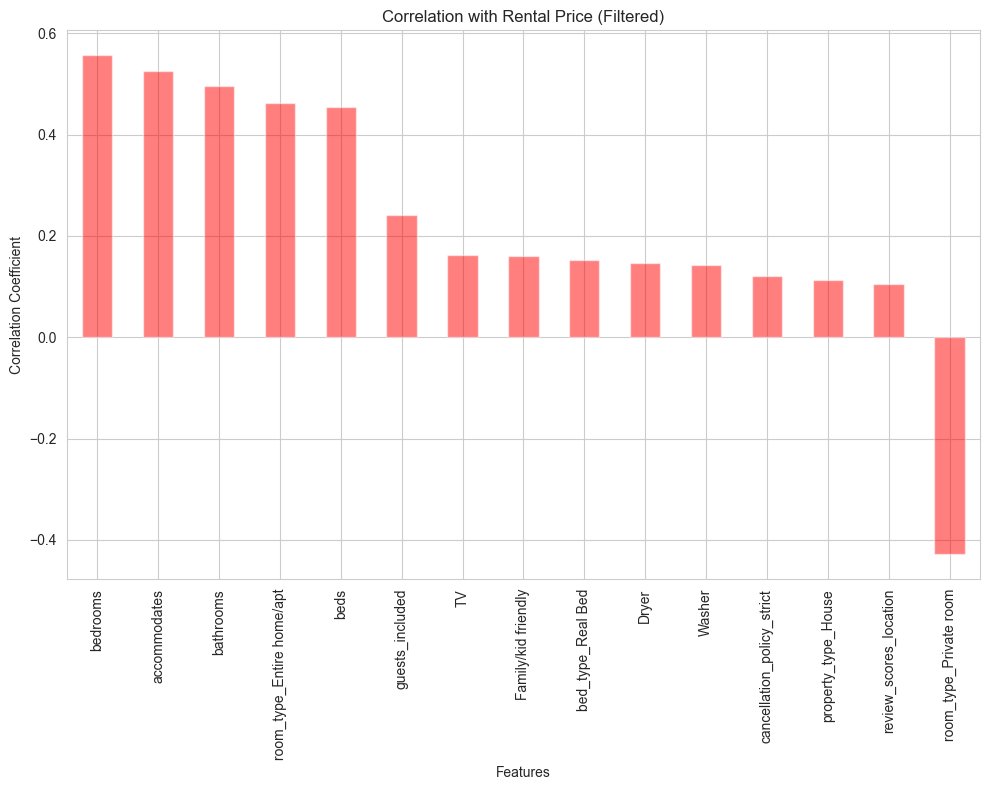

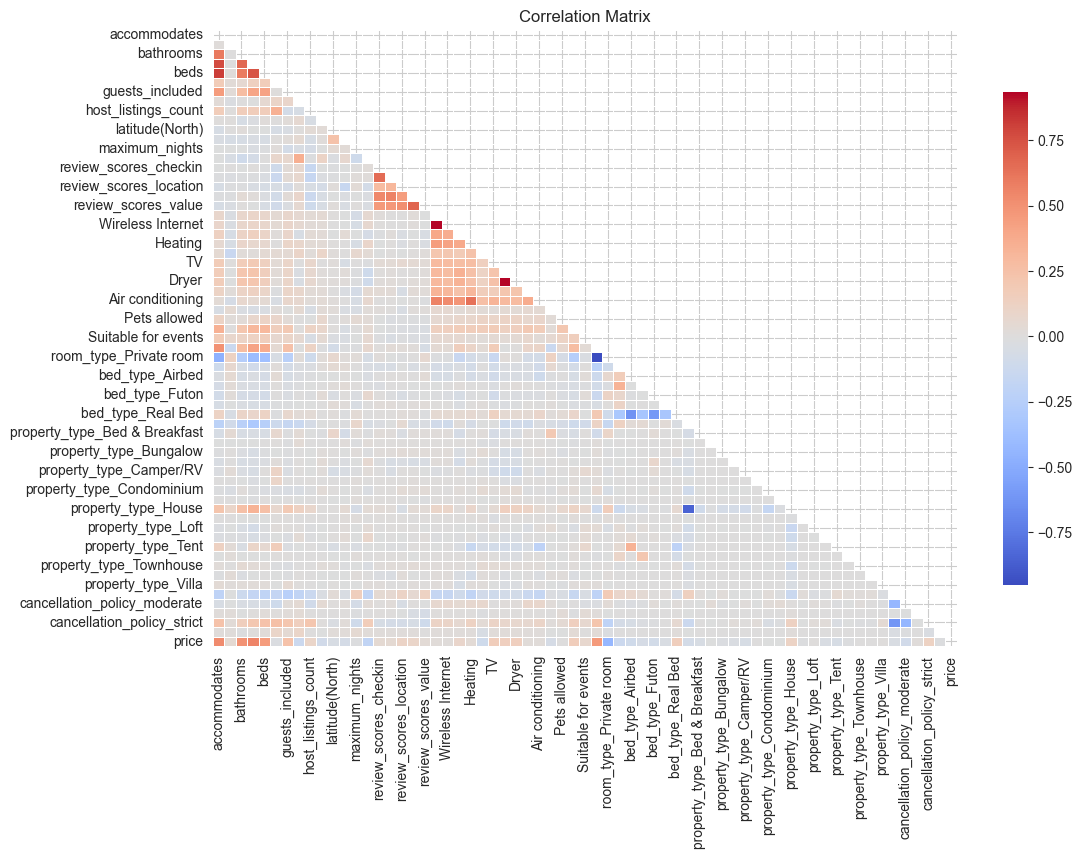

In [8]:
# Calculate the correlation
correlation_matrix = merged_df.corr()
rental_price_correlation = correlation_matrix['price'].sort_values(ascending=False)
pd.set_option('display.max_columns', 15) #(prev: none)
print("Correlation with rental price:")
print(rental_price_correlation)

# Filter features based on correlation threshold
filtered_rental_price_correlation = rental_price_correlation.drop('price')[
    (rental_price_correlation.drop('price') > 0.1) | (rental_price_correlation.drop('price') < -0.1)
    ]

# Plot the filtered rental price correlation
plt.figure(figsize=(10, 8))
filtered_rental_price_correlation.plot(kind='bar', color='red', alpha=0.5)
plt.title('Correlation with Rental Price (Filtered)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize the correlation matrix with a mask for the upper triangle
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
sns.heatmap(correlation_matrix, mask=mask, fmt='.2f', cmap='coolwarm', cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix')
plt.show()


## Model training

In [9]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=25),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regressor': AdaBoostRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
    'Neural Network Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse=np.sqrt(mse)
    results[name] = {'MSE': mse, 'R^2': r2, 'RSME': rmse }
    print(f"\n{name}: \n Mean Squared Error: {mse}\n Root Mean Squared Error: {rmse},\n R^2 Score: {r2}\n")



Linear Regression: 
 Mean Squared Error: 3.357442340660032e+21
 Root Mean Squared Error: 57943440876.9451,
 R^2 Score: -1.4867879153746314e+17


Ridge Regression: 
 Mean Squared Error: 11051.064448780415
 Root Mean Squared Error: 105.12404315274605,
 R^2 Score: 0.5106218541569092


Elastic Net: 
 Mean Squared Error: 17925.391049923892
 Root Mean Squared Error: 133.88573878469614,
 R^2 Score: 0.20620364887183418


Decision Tree: 
 Mean Squared Error: 17896.77024482109
 Root Mean Squared Error: 133.7788108962742,
 R^2 Score: 0.20747107397813602


Random Forest: 
 Mean Squared Error: 8278.452247457628
 Root Mean Squared Error: 90.98600028277772,
 R^2 Score: 0.6334024084206225



  File "C:\Users\I568830\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



KNN Regressor: 
 Mean Squared Error: 14194.355260263656
 Root Mean Squared Error: 119.14006572208888,
 R^2 Score: 0.37142640956432493


Support Vector Regressor: 
 Mean Squared Error: 20278.59093204699
 Root Mean Squared Error: 142.40291756859125,
 R^2 Score: 0.10199607679142042


Gradient Boosting Regressor: 
 Mean Squared Error: 8762.049586576159
 Root Mean Squared Error: 93.60582026015348,
 R^2 Score: 0.6119870985878582


AdaBoost Regressor: 
 Mean Squared Error: 11873.566197010245
 Root Mean Squared Error: 108.96589465062105,
 R^2 Score: 0.4741987220353844


Extra Trees Regressor: 
 Mean Squared Error: 9756.326179849342
 Root Mean Squared Error: 98.77411695302237,
 R^2 Score: 0.5679572010222066


Neural Network Regressor: 
 Mean Squared Error: 11259.857569218057
 Root Mean Squared Error: 106.11247603000345,
 R^2 Score: 0.5013757954972982



## Hyperparameter Tuning
Attempt to find the right parameters for model performance while preventing overfitting. 

In [10]:
# Define the hyperparameter grids
param_grid_gbr = {
    'n_estimators': [100,300,400,500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'min_samples_split':[5,10,15]}

param_grid_rf = {
    'n_estimators': [100, 500, 700, 800, 900], #prev no 7+
    'max_depth': [10, 25, 30, 40],
    'min_samples_split': [ 5, 15, 30]}

# Initialize the models
gbr = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV for each model
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

# Fit the models
grid_search_gbr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Best parameters and scores
best_gbr = grid_search_gbr.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Predict and evaluate
models = {
    'Gradient Boosting Regressor': best_gbr,
    'Random Forest Regressor': best_rf,
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {'MSE': mse, 'R^2': r2, 'RMSE': rmse}
    print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}, Root Mean Squared Error: {rmse}")

# Print best parameters
print("Best parameters for Gradient Boosting Regressor: ", grid_search_gbr.best_params_)
print("Best parameters for Random Forest Regressor: ", grid_search_rf.best_params_)


Gradient Boosting Regressor - Mean Squared Error: 8588.69642304656, R^2 Score: 0.6196637572606353, Root Mean Squared Error: 92.67522011328897
Random Forest Regressor - Mean Squared Error: 8203.930420383593, R^2 Score: 0.6367024845107908, Root Mean Squared Error: 90.57555089748885
Best parameters for Gradient Boosting Regressor:  {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best parameters for Random Forest Regressor:  {'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 900}


## Feature Importance

Apply a permutation importance test to check for important features and improve the model accordingly.

In [11]:
# Dictionary to store the permutation importance results
permutation_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}")

    # Calculate permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=42, n_jobs=-1)
    permutation_importances[name] = r

# Define a function to retrain and evaluate models with selected features
def retrain_models(features_subset, models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        X_train_selected = X_train[features_subset]
        X_test_selected = X_test[features_subset]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MSE': mse, 'R^2': r2, 'Model': model}
        print(f"{name} (Top {len(features_subset)} Features) - Mean Squared Error: {mse}, R^2 Score: {r2}")
    return results

# Initialize dictionary to store best models and features
best_models = {}

# Evaluate each set of top features for best model selection
top_features_counts = [15, 25, 30, 35, 40, 45]
for model_name in models.keys():
    best_r2 = float('-inf')
    best_features = None
    best_model = None

    for top_n in top_features_counts:
        indices = np.argsort(permutation_importances[model_name].importances_mean)[::-1][:top_n]
        features_subset = X_test.columns[indices]
        results = retrain_models(features_subset, {model_name: models[model_name]}, X_train, y_train, X_test, y_test)

        if results[model_name]['R^2'] > best_r2:
            best_r2 = results[model_name]['R^2']
            best_features = features_subset
            best_model = results[model_name]['Model']

    best_models[model_name] = {'Model': best_model, 'Features': best_features, 'R2': best_r2}

# Print best models and their performance
for name, details in best_models.items():
    print(f"Best model for {name}: R^2 Score: {details['R2']}")
    print(f"Selected important features for {name}: {details['Features']}")

# Update the models dictionary with the best models
models = {
    name: details['Model'] for name, details in best_models.items()
}

Gradient Boosting Regressor - Mean Squared Error: 8588.69642304656, R^2 Score: 0.6196637572606353
Random Forest Regressor - Mean Squared Error: 8203.930420383593, R^2 Score: 0.6367024845107908
Gradient Boosting Regressor (Top 15 Features) - Mean Squared Error: 8535.827581852236, R^2 Score: 0.6220049666162106
Gradient Boosting Regressor (Top 25 Features) - Mean Squared Error: 8486.1025348182, R^2 Score: 0.6242069582372225
Gradient Boosting Regressor (Top 30 Features) - Mean Squared Error: 8458.289584066122, R^2 Score: 0.6254386088472214
Gradient Boosting Regressor (Top 35 Features) - Mean Squared Error: 8380.885647238521, R^2 Score: 0.6288663144099944
Gradient Boosting Regressor (Top 40 Features) - Mean Squared Error: 8460.807116487758, R^2 Score: 0.6253271240799114
Gradient Boosting Regressor (Top 45 Features) - Mean Squared Error: 8518.440317782726, R^2 Score: 0.6227749329023596
Random Forest Regressor (Top 15 Features) - Mean Squared Error: 8137.08915947021, R^2 Score: 0.639662439407

In [12]:
# # Dictionary to store the permutation importance results
# permutation_importances = {}
# 
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}")
# 
#     # Calculate permutation importance
#     r = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=42, n_jobs= -1)
#     permutation_importances[name] = r
# 
# # Plot permutation importance for each model
# for name, r in permutation_importances.items():
#     importances = r.importances_mean
#     std = r.importances_std
#     indices = np.argsort(importances)[::-1]
# 
#     # Limit to top 30 features
#     indices = indices[:30]
#     importances = importances[indices]
#     std = std[indices]
#     features_to_plot = X_test.columns[indices]
# 
#     plt.figure(figsize=(10, 8))
#     plt.title(f"Top 30 Feature Importances for {name}")
#     plt.barh(features_to_plot, importances, color="r", xerr=std, align="center")
#     plt.gca().invert_yaxis()
#     plt.tight_layout(pad=2.0) 
#     plt.show()
# 
# # Select the top 30 important features based on Random Forest as an example
# model_name = 'Random Forest Regressor'
# top_n_features = 30
# important_features = X_test.columns[np.argsort(permutation_importances[model_name].importances_mean)[::-1][:top_n_features]]
# print(f"Selected top {top_n_features} important features from {model_name}: {important_features}")
# 
# # Retrain and evaluate models with selected features
# X_train_selected = X_train[important_features]
# X_test_selected = X_test[important_features]
# 
# results_selected = {}
# for name, model in models.items():
#     model.fit(X_train_selected, y_train)
#     y_pred = model.predict(X_test_selected)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     results_selected[name] = {'MSE': mse, 'R^2': r2}
#     print(f"{name} (Selected Features) - Mean Squared Error: {mse}, R^2 Score: {r2}")


Gradient Boosting Regressor (Selected Features) - Mean Squared Error: 8019.159931925718, R^2 Score: 0.6125929360390938
Random Forest Regressor (Selected Features) - Mean Squared Error: 8001.567156337675, R^2 Score: 0.6134428462036676

# Undervalued Hotels

In [14]:
# get best model
sel_model = best_rf_model = best_models['Random Forest Regressor']['Model']
important_features = best_models['Random Forest Regressor']['Features']

# Predict prices for the entire dataset using the selected features
features_selected = X[important_features]
predicted_prices = sel_model.predict(features_selected)

# Add predicted prices to the data and calculate differences
merged_df['predicted_price'] = predicted_prices
merged_df['price_difference'] = merged_df['price'] - merged_df['predicted_price']
merged_df['percentage_difference'] = (merged_df['price_difference'] / merged_df['predicted_price']) * 100

# Identify significantly undervalued hotels (1/3 as threshold)
significant_threshold = -(1/3)*100  # Negative because actual price is lower than predicted
significantly_undervalued_hotels = merged_df[merged_df['percentage_difference'] < significant_threshold]

# Display the total count of significantly undervalued hotels
total_undervalued_hotels = len(significantly_undervalued_hotels)
print(f"Total number of significantly undervalued hotels: {total_undervalued_hotels}")

# Display the significantly undervalued hotels
significantly_undervalued_hotels[['price', 'predicted_price', 'price_difference', 'percentage_difference']]

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- cancellation_policy_no_refunds
- property_type_Chalet
- property_type_Hut
- property_type_Tipi
- property_type_Treehouse


We were able to identify 772 Hotels in the data, that are potentially undervalued.

## Analysis of undervalued Hotels

In [ ]:
# Add a column to distinguish between undervalued and all hotels
merged_df['category'] = 'All Hotels'
significantly_undervalued_hotels['category'] = 'Undervalued Hotels'

# Combine the dataframes
comparison_df = pd.concat([merged_df, significantly_undervalued_hotels])

# Function to perform t-test for continuous variables and chi-square test for categorical variables
def test_significance(df, feature, categorical=False):
    group1 = df[df['category'] == 'All Hotels'][feature]
    group2 = df[df['category'] == 'Undervalued Hotels'][feature]
    if categorical:
        contingency_table = pd.crosstab(df['category'], df[feature])
        _, p_value, _, _ = chi2_contingency(contingency_table)
    else:
        _, p_value = ttest_ind(group1, group2, nan_policy='omit')
    return p_value

# List of features to test
features_to_test = [
    'review_scores_rating', 'number_of_reviews', 'bathrooms', 'availability_30',
    'accommodates', 'host_listings_count', 'bedrooms', 'beds',
    'maximum_nights', 'guests_included', 'room_type_Entire home/apt', 'room_type_Private room',
    'Essentials', 'Kitchen', 'Washer', 'Dryer',
    'Heating', 'Internet', 'Wireless Internet', 'Air conditioning'
]

# Determine significant features
significant_features = []
alpha = 0.05  # significance level

for feature in features_to_test:
    categorical = 'room_type' in feature or feature in ['Essentials', 'Kitchen', 'Washer', 'Dryer', 'Heating', 'Internet', 'Wireless Internet', 'Air conditioning']
    p_value = test_significance(comparison_df, feature, categorical=categorical)
    if p_value < alpha:
        significant_features.append(feature)

print(f"Significant features: {significant_features[:10]}")

# Calculate mean percentage differences
mean_percentage_diffs = []
for feature in significant_features[:10]:
    mean_all = comparison_df[comparison_df['category'] == 'All Hotels'][feature].mean()
    mean_undervalued = comparison_df[comparison_df['category'] == 'Undervalued Hotels'][feature].mean()
    mean_diff = (mean_undervalued - mean_all) / mean_all * 100
    mean_percentage_diffs.append(mean_diff)

# Create a bar plot for mean percentage differences
plt.figure(figsize=(14, 8))
sns.barplot(x=significant_features[:10], y=mean_percentage_diffs, color='red', alpha=0.5)
plt.title('Mean Percentage Differences of Significant Features Between Undervalued and All Hotels')
plt.xlabel('Features')
plt.ylabel('Mean Percentage Difference (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Map of undervalued Hotels

In [ ]:
# Apply inverse transform to scale back the data
significantly_undervalued_hotels[numerical_columns] = scaler.inverse_transform(significantly_undervalued_hotels[numerical_columns])

# Create a plot
fig, ax = plt.subplots(figsize=(25, 15))

# Plot the data points with color corresponding to the price
sc = ax.scatter(significantly_undervalued_hotels['longitude(East)'], significantly_undervalued_hotels['latitude(North)'],
                c=significantly_undervalued_hotels['price'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, zorder=1)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Price')

# Set plot title and labels
ax.set_title('Undervalued Hotels')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove gridlines
ax.grid(False)

# Set axis limits explicitly to prevent image from affecting zoom
ax.set_xlim(113.9, 114.4)
ax.set_ylim(22.45, 22.9)

# Show the plot
plt.show()

## Cluster Analysis
We tried a cluster analysis of the undervalued hotels, however, we couldn't find any interesting insights.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select the features of the significantly undervalued hotels for clustering
features_for_clustering = significantly_undervalued_hotels[important_features]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Determine the optimal number of clusters using the elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Apply K-Means clustering with the optimal number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Add the cluster labels to the significantly undervalued hotels dataframe
significantly_undervalued_hotels = significantly_undervalued_hotels.copy()
significantly_undervalued_hotels.loc[:, 'cluster'] = clusters

# Analyze the clusters and generate summary values
for cluster in range(optimal_clusters):
    cluster_data = significantly_undervalued_hotels[significantly_undervalued_hotels['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data[['price', 'predicted_price', 'price_difference', 'percentage_difference'] + important_features.tolist()])
    print(f"Number of hotels in cluster {cluster}: {len(cluster_data)}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Insights from Significantly Undervalued Hotels by Cluster', fontsize=16)

# Plot 1: Distribution of Price Differences by Cluster
sns.boxplot(x='cluster', y='price_difference', data=significantly_undervalued_hotels, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Price Differences by Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Price Difference')

# Plot 2: Percentage Differences by Cluster
sns.boxplot(x='cluster', y='percentage_difference', data=significantly_undervalued_hotels, ax=axes[0, 1])
axes[0, 1].set_title('Percentage Differences by Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Percentage Difference')

# Plot 3: Number of Bedrooms by Cluster
sns.boxplot(x='cluster', y='bedrooms', data=significantly_undervalued_hotels, ax=axes[1, 0])
axes[1, 0].set_title('Number of Bedrooms by Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Bedrooms')

# Plot 4: Room Types by Cluster
room_types = significantly_undervalued_hotels[['cluster', 'room_type_Entire home/apt', 'room_type_Private room']].melt(id_vars='cluster', var_name='Room Type', value_name='Count')
sns.barplot(x='cluster', y='Count', hue='Room Type', data=room_types, ax=axes[1, 1])
axes[1, 1].set_title('Room Types by Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Count')

# Plot 5: Review Scores by Cluster
sns.boxplot(x='cluster', y='review_scores_rating', data=significantly_undervalued_hotels, ax=axes[2, 0])
axes[2, 0].set_title('Review Scores by Cluster')
axes[2, 0].set_xlabel('Cluster')
axes[2, 0].set_ylabel('Review Scores Rating')

# Plot 6: Host is Superhost by Cluster
superhost = significantly_undervalued_hotels[['cluster', 'host_is_superhost']].groupby('cluster').sum().reset_index()
sns.barplot(x='cluster', y='host_is_superhost', data=superhost, ax=axes[2, 1])
axes[2, 1].set_title('Number of Superhosts by Cluster')
axes[2, 1].set_xlabel('Cluster')
axes[2, 1].set_ylabel('Count of Superhosts')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
